## Step 1: Dataset Selection

In [53]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Dataset/HR-Employee-Attrition.csv")


## Step 2: Business Problem Definition
Employee attrition (staff leaving an organization) is one of the most critical challenges in Human Resource (HR) management. High attrition rates lead to increased recruitment costs, loss of skilled workers, lower employee morale, and disruption in business operations. Understanding the factors that influence attrition is therefore essential for developing effective retention strategies, improving employee satisfaction, and ensuring long-term organizational stability.

Based on the IBM HR Analytics Employee Attrition Dataset, the following business questions and hypotheses are formulated:



---


1. Is attrition rate significantly different across job roles?

* Business relevance: Different job roles may experience varying levels of stress, workload, and career growth opportunities. If attrition is higher in certain roles, HR can design role-specific interventions such as training, career development, or workload adjustments.

* Hypotheses:

  * H₀ (Null Hypothesis): Employee attrition rate does not significantly differ across job roles.

  * H₁ (Alternative Hypothesis): Employee attrition rate significantly differs across job roles.


---

2. Is attrition rate significantly different across departments?

* Business relevance: Some departments (e.g., Sales or Research & Development) may have higher turnover due to workload intensity, market pressures, or limited career progression. Identifying these differences helps HR prioritize resources and develop targeted retention policies.

* Hypotheses:

  * H₀ (Null Hypothesis): Employee attrition rate does not significantly differ between departments.

  * H₁ (Alternative Hypothesis): Employee attrition rate significantly differs between departments.


---

3. Do employees who work overtime have higher attrition compared to those who don’t?

* Business relevance: Overtime can cause fatigue, burnout, and dissatisfaction. If overtime is significantly linked to higher attrition, organizations should consider redesigning work schedules or hiring additional staff.

* Hypotheses:

  * H₀ (Null Hypothesis): Overtime has no significant relationship with employee attrition.

  * H₁ (Alternative Hypothesis): Overtime is significantly related to employee attrition.

---
4. Does monthly income differ significantly between employees who left and those who stayed?

* Business relevance: Compensation is a key factor in employee retention. If employees who left have significantly lower incomes, HR should reassess salary structures to remain competitive and retain talent.

* Hypotheses:

  * H₀ (Null Hypothesis): There is no significant difference in monthly income between employees who left and those who stayed.

  * H₁ (Alternative Hypothesis): There is a significant difference in monthly income between employees who left and those who stayed.

---

5. Is there a significant relationship between years at the company and employee attrition?

* Business relevance: Employee tenure may influence attrition — new employees might leave due to poor onboarding, while long-tenured employees may stay due to job security or may leave due to retirement. Understanding this helps HR design retention strategies for different career stages.

* Hypotheses:

  * H₀ (Null Hypothesis): There is no significant relationship between years at company and attrition.

  * H₁ (Alternative Hypothesis): There is a significant relationship between years at company and attrition.

---



## Step 3: Data Cleaning & Preprocessing

In [55]:
import os
print(os.getcwd())   # shows the current working directory


/content


In [56]:
# Step 3.1 – Check & Handle Missing Values
import pandas as pd

# Load dataset (use correct path, or reuse df if already loaded above)
df = pd.read_csv("/content/drive/MyDrive/Dataset/HR-Employee-Attrition.csv")

# Check missing values
print("Missing values in each column:\n", df.isnull().sum())

# Handle missing values (if any)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == "object":  # categorical → fill with mode
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:  # numerical → fill with median
            df[col].fillna(df[col].median(), inplace=True)

print("\nMissing values after handling:\n", df.isnull().sum())


Missing values in each column:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInC

In [57]:
# Step 3.2 – Encode Categorical Variables
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical columns:", categorical_cols.tolist())

# Encode each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # save for inverse transform if needed



Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


In [58]:
# Step 3.3 – Standardize/Normalize Numerical Variables
from sklearn.preprocessing import StandardScaler

# Identify numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nNumerical columns:", numerical_cols.tolist())

# Standardize numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



Numerical columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [59]:
# Step 3.4 – Remove Extreme Outliers (IQR Method)
# Choose only relevant continuous variables for outlier removal
outlier_cols = ['Age', 'MonthlyIncome', 'DailyRate', 'DistanceFromHome', 'YearsAtCompany']

def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

# Apply only on selected continuous columns
for col in outlier_cols:
    df = remove_outliers_iqr(df, col)

print("Dataset shape after safer outlier removal:", df.shape)


Dataset shape after safer outlier removal: (1304, 35)


## Step 4: Exploratory Data Analysis (EDA)

In [60]:
# STEP 4.0 — Setup & Quick Overview

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (7, 4)

# Load dataset (raw)
file_path = r"/content/drive/MyDrive/Dataset/HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)

# Clean Attrition values
df['Attrition'] = df['Attrition'].astype(str).str.strip().str.title()

print("=== Quick Overview ===")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")

print("\nData types (count):")
print(df.dtypes.value_counts())

cat_cols = [c for c in df.columns if df[c].dtype == 'O']
num_cols = [c for c in df.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}{' …' if len(num_cols)>10 else ''}")

print("\nAttrition counts:")
print(df['Attrition'].value_counts())


=== Quick Overview ===
Shape: 1470 rows × 35 cols

Data types (count):
int64     26
object     9
Name: count, dtype: int64

Categorical columns (9): ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Numeric columns (26): ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel'] …

Attrition counts:
Attrition
No     1233
Yes     237
Name: count, dtype: int64


/tmp/ipython-input-1527389243.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




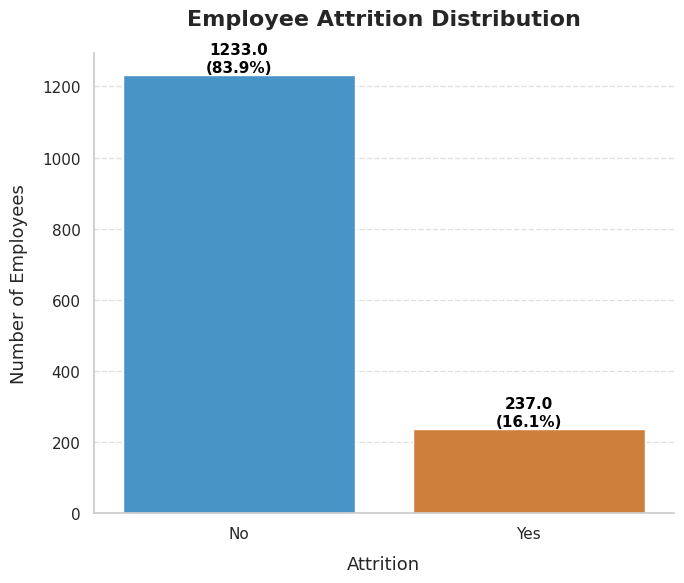

In [61]:
# STEP 4.1 — Attrition Class Balance

colors = ["#3498db", "#e67e22"]  # blue=No, orange=Yes
fig, ax = plt.subplots(figsize=(7,6))
sns.countplot(x="Attrition", data=df, order=["No", "Yes"], palette=colors, ax=ax)

# Labels & title
ax.set_title("Employee Attrition Distribution", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Attrition", fontsize=13, labelpad=10)
ax.set_ylabel("Number of Employees", fontsize=13, labelpad=10)

# Annotate counts + %
total = len(df)
for p in ax.patches:
    height = p.get_height()
    pct = 100 * height / total
    ax.annotate(f"{height}\n({pct:.1f}%)",
                (p.get_x() + p.get_width()/2., height),
                ha="center", va="bottom",
                fontsize=11, fontweight="bold", color="black")

sns.despine()
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


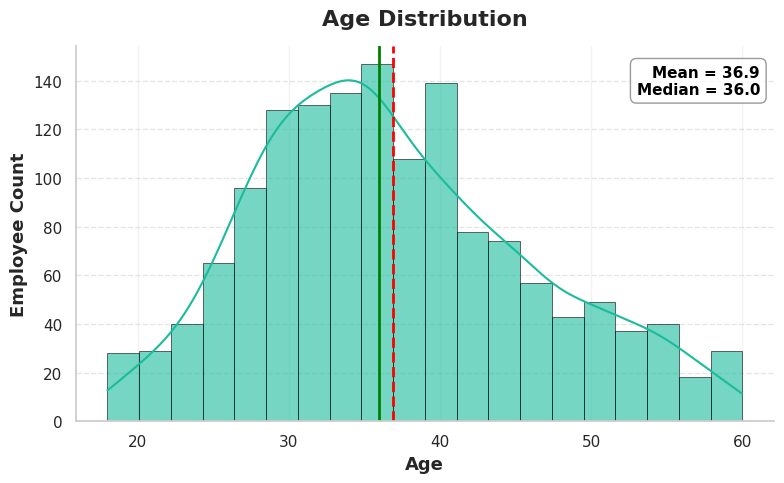

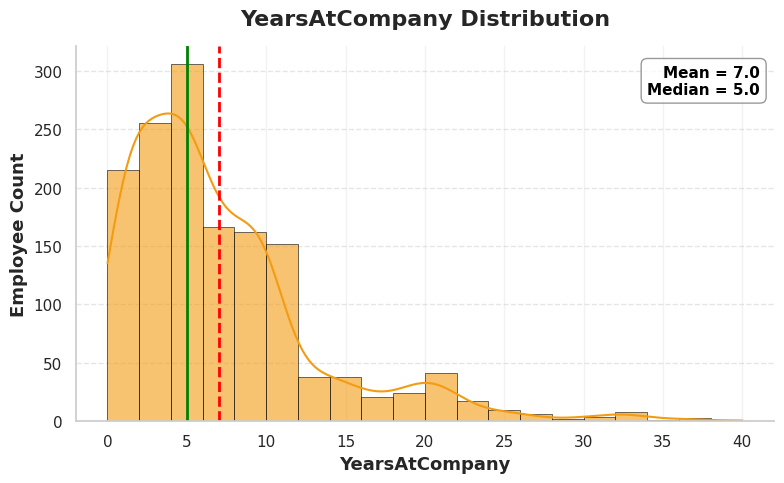

In [62]:
# STEP 4.2 — Distribution Plots (Age & YearsAtCompany)

def fancy_distribution(data, column, color, bins=20):
    plt.figure(figsize=(8,5))
    sns.histplot(data[column], bins=bins, kde=True,
                 color=color, alpha=0.6, edgecolor="black", linewidth=0.4)

    # Mean & Median
    mean_val = data[column].mean()
    median_val = data[column].median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label="Mean")
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label="Median")

    # Labels & title
    plt.title(f"{column} Distribution", fontsize=16, fontweight="bold", pad=15)
    plt.xlabel(column, fontsize=13, fontweight="bold")
    plt.ylabel("Employee Count", fontsize=13, fontweight="bold")

    # Stats box
    stats_text = f"Mean = {mean_val:.1f}\nMedian = {median_val:.1f}"
    plt.gca().text(
        0.98, 0.95, stats_text,
        transform=plt.gca().transAxes, fontsize=11, fontweight="bold",
        color="black", ha="right", va="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray", alpha=0.8)
    )

    sns.despine()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Age distribution
fancy_distribution(df, 'Age', color="#1abc9c")

# Years at Company distribution
fancy_distribution(df, 'YearsAtCompany', color="#f39c12")


/tmp/ipython-input-1868243103.py:7: UserWarning:

The palette list has more values (8) than needed (2), which may not be intended.



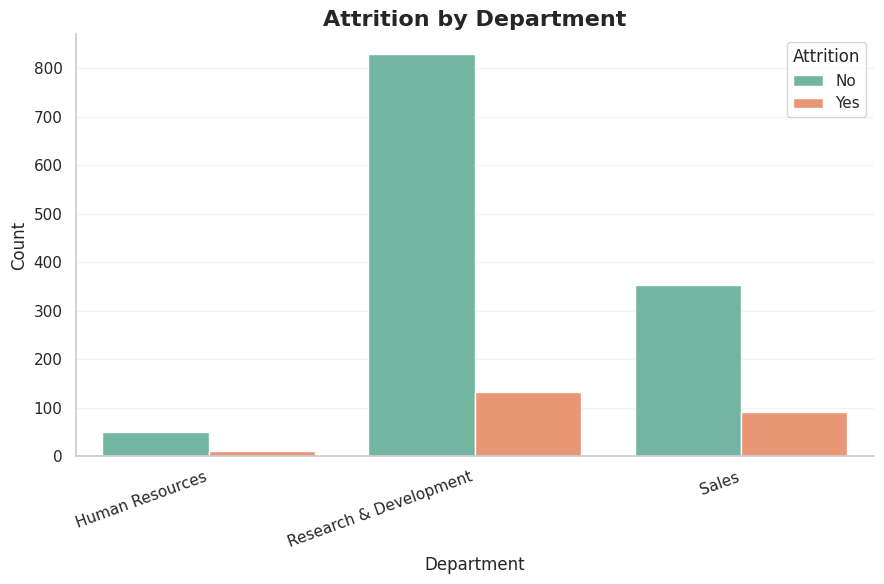

/tmp/ipython-input-1868243103.py:20: UserWarning:

The palette list has more values (8) than needed (2), which may not be intended.



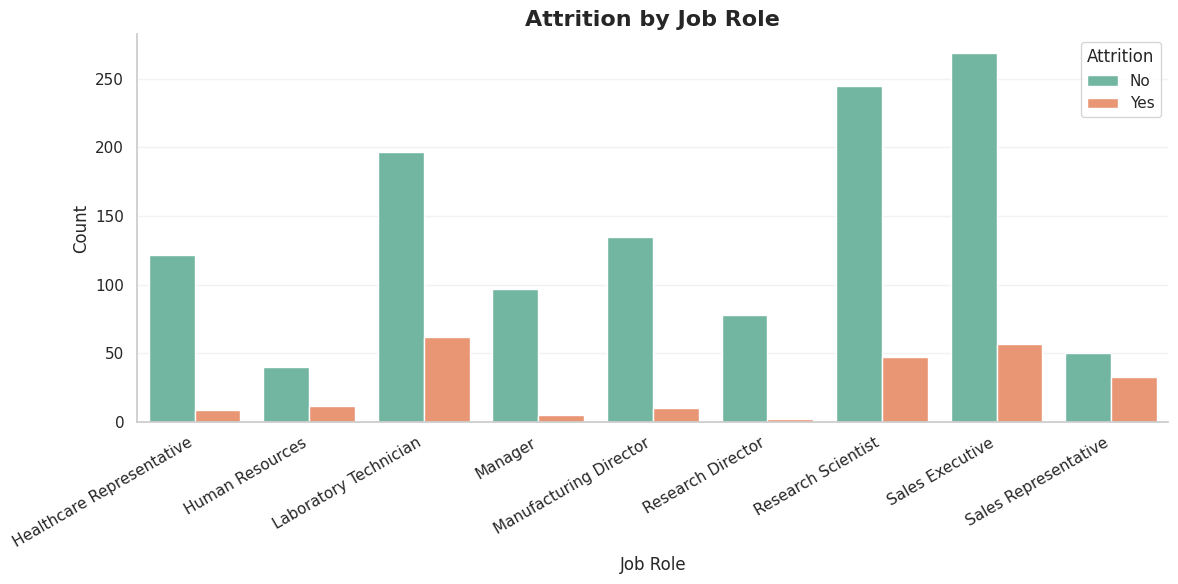

In [63]:
# STEP 4.3 — Comparative Plots: Attrition by Department & Job Role

palette = sns.color_palette("Set2")

# Department vs Attrition
plt.figure(figsize=(9, 6))
ax = sns.countplot(
    data=df, x="Department", hue="Attrition",
    order=sorted(df["Department"].unique()),
    hue_order=["No","Yes"], palette=palette
)
plt.title("Attrition by Department", fontsize=16, weight="bold")
plt.xlabel("Department"); plt.ylabel("Count")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Attrition")
sns.despine(); plt.tight_layout(); plt.show()

# Job Role vs Attrition
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df, x="JobRole", hue="Attrition",
    order=sorted(df["JobRole"].unique()),
    hue_order=["No","Yes"], palette=palette
)
plt.title("Attrition by Job Role", fontsize=16, weight="bold")
plt.xlabel("Job Role"); plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Attrition")
sns.despine(); plt.tight_layout(); plt.show()


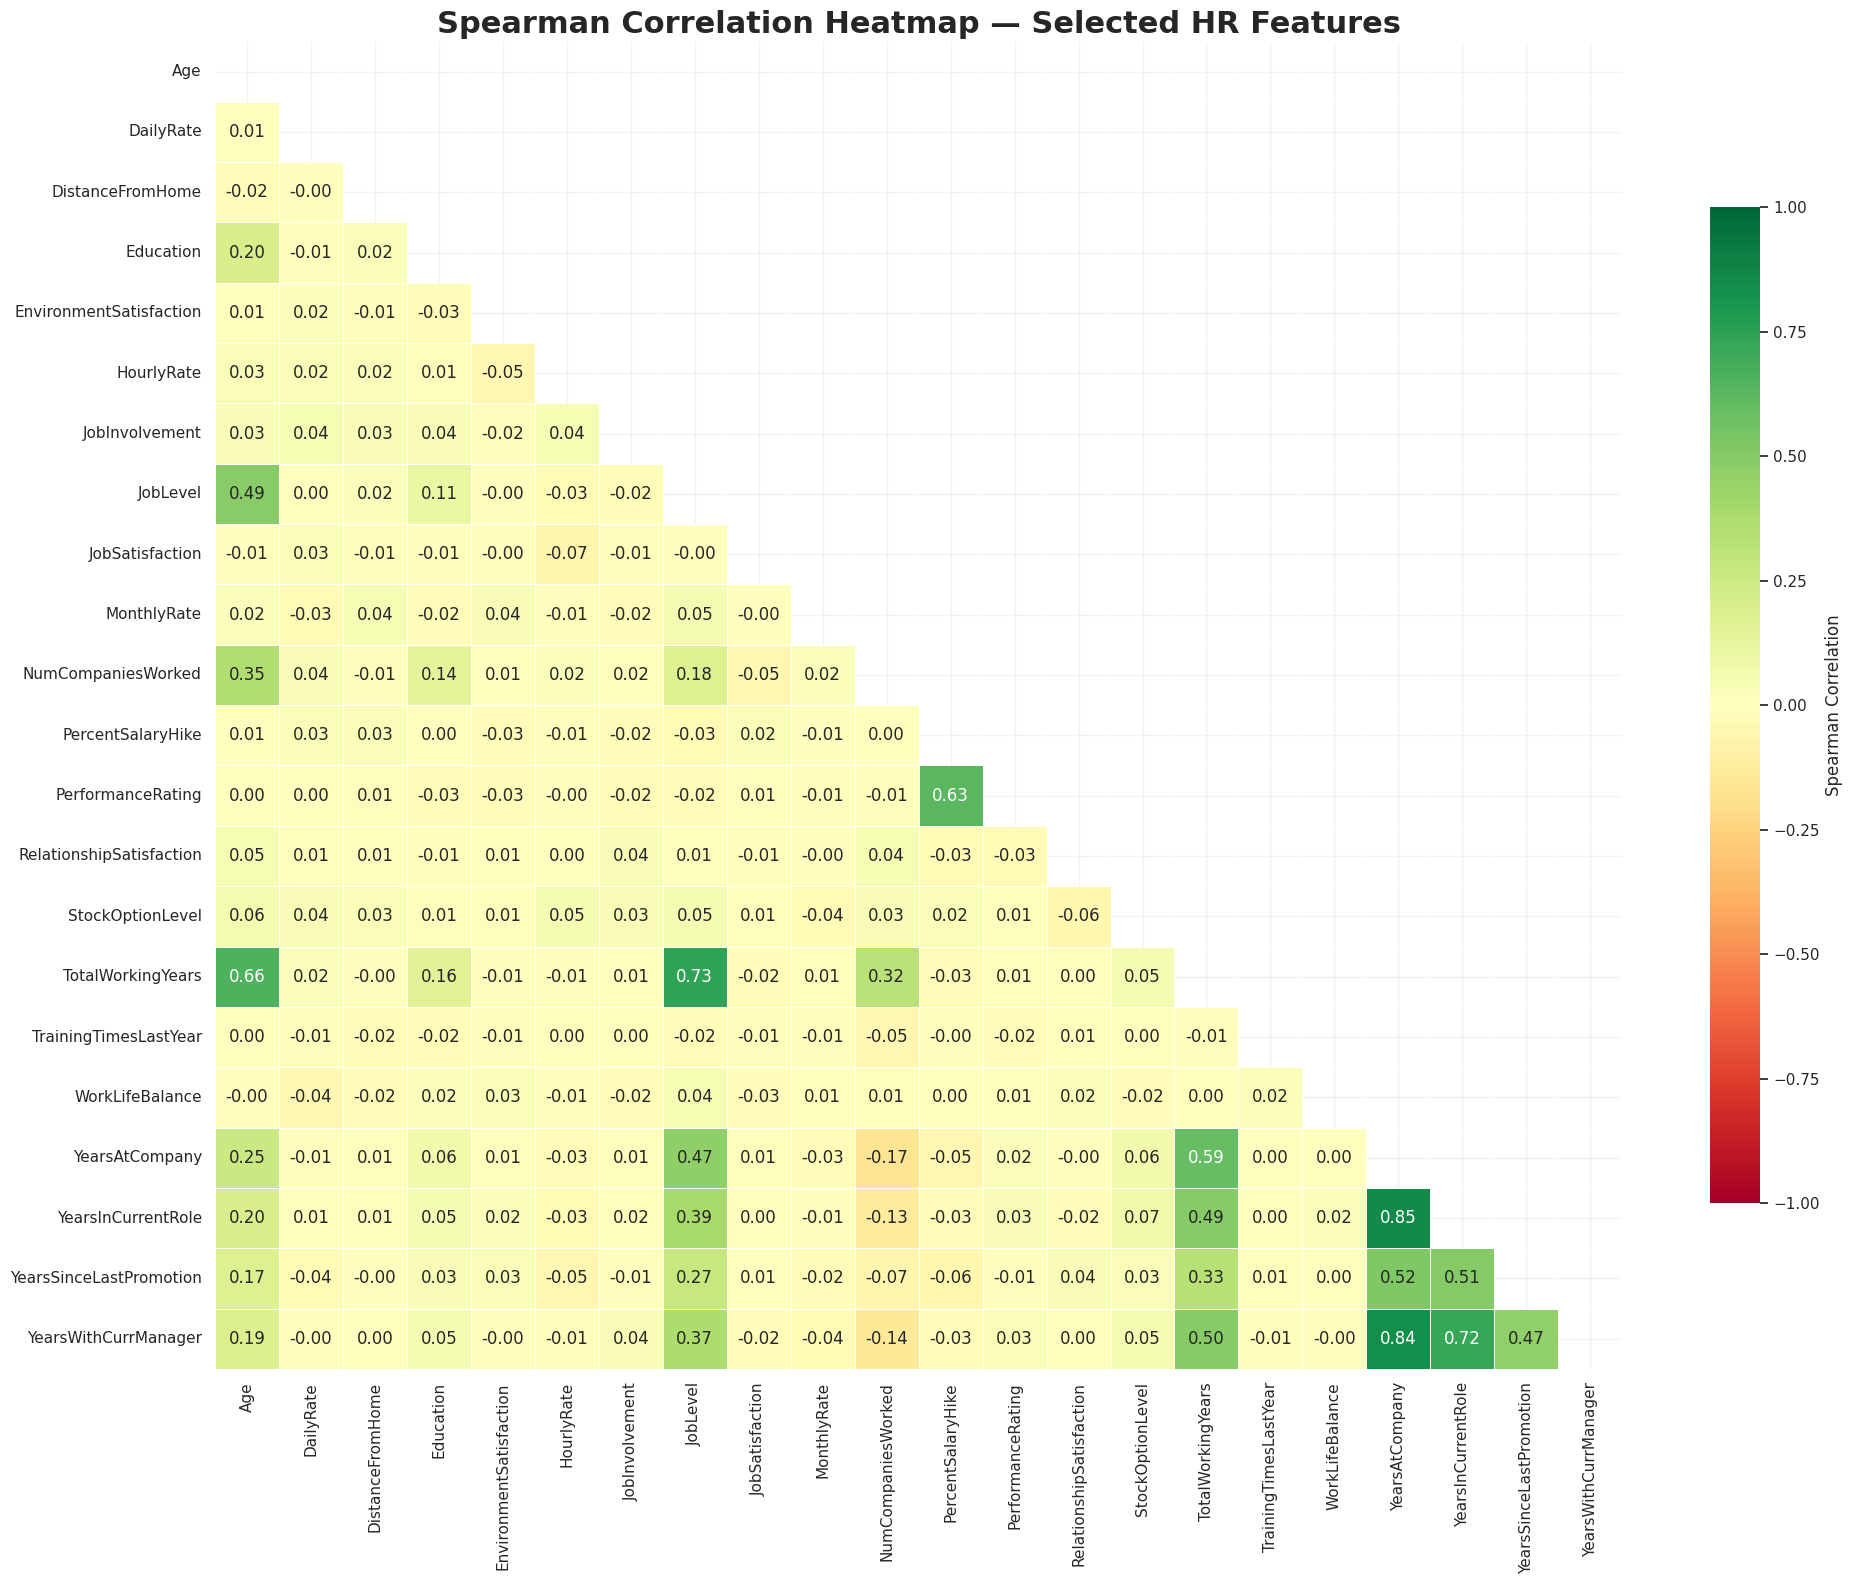

In [64]:
# STEP 4.4 — Correlation Heatmap (excluding MonthlyIncome & OverTime)

num_cols = [c for c in ['Age','DailyRate','DistanceFromHome','Education',
                        'EnvironmentSatisfaction','HourlyRate','JobInvolvement',
                        'JobLevel','JobSatisfaction','MonthlyRate','NumCompaniesWorked',
                        'PercentSalaryHike','PerformanceRating','RelationshipSatisfaction',
                        'StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear',
                        'WorkLifeBalance','YearsAtCompany','YearsInCurrentRole',
                        'YearsSinceLastPromotion','YearsWithCurrManager']
            if c in df.columns]

corr = df[num_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20,16))
sns.heatmap(corr, mask=mask, cmap="RdYlGn", center=0, vmin=-1, vmax=1,
            annot=True, fmt=".2f", linewidths=0.7, linecolor="white",
            cbar_kws={"shrink": .75, "label": "Spearman Correlation"})
plt.title("Spearman Correlation Heatmap — Selected HR Features", fontsize=22, weight="bold")
plt.tight_layout()
plt.show()


In [65]:
# STEP 4.5 — Interactive Plot: Attrition Rate by Age with Department Filter

import plotly.express as px

tmp = pd.DataFrame({
    "Age": df['Age'].astype(int),
    "Department": df['Department'].astype(str),
    "AttritionNum": (df['Attrition'] == "Yes").astype(int)
})

# Compute attrition rate by Age within each Department
agg = (tmp.groupby(['Department','Age'])['AttritionNum']
          .mean()
          .reset_index()
          .rename(columns={'AttritionNum':'AttritionRate'}))
agg['AttritionRate'] = agg['AttritionRate'] * 100

departments = sorted(agg['Department'].unique())
fig = px.scatter(
    agg[agg['Department'] == departments[0]],
    x="Age", y="AttritionRate",
    trendline="lowess",
    title=f"Attrition Rate by Age — Department: {departments[0]}",
    labels={"AttritionRate":"Attrition Rate (%)"}
)

# Dropdown filter for departments
buttons = []
for dept in departments:
    visible_df = agg[agg['Department'] == dept]
    buttons.append(dict(
        label=dept,
        method="update",
        args=[{"x": [visible_df["Age"]], "y": [visible_df["AttritionRate"]]},
              {"title": f"Attrition Rate by Age — Department: {dept}"}]
    ))

fig.update_layout(
    updatemenus=[dict(type="dropdown", x=0.0, y=1.2,
                      xanchor="left", yanchor="top", buttons=buttons)],
    xaxis_title="Age", yaxis_title="Attrition Rate (%)"
)

fig.show()


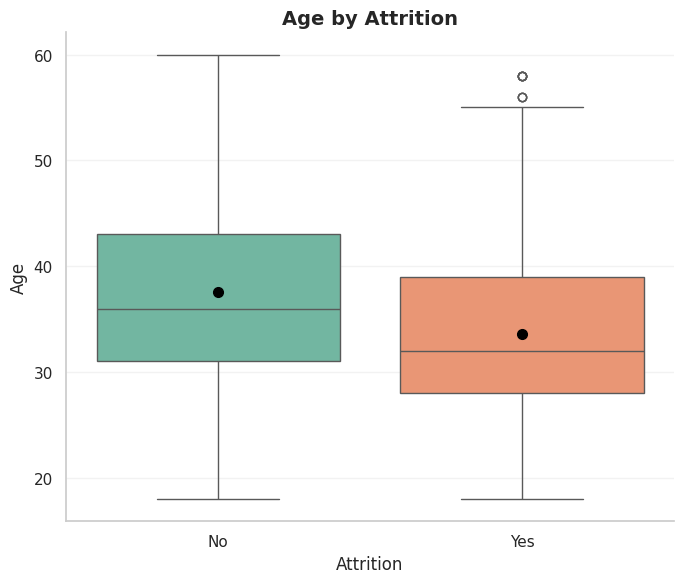

In [66]:
# STEP 4.6 — Boxplot: Age vs Attrition

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7,6))

sns.boxplot(
    data=df,
    x="Attrition",
    y="Age",
    order=["No","Yes"],
    hue="Attrition",
    hue_order=["No","Yes"],
    dodge=False,
    palette="Set2",
    legend=False,
    showmeans=True,
    meanprops={"marker":"o","markerfacecolor":"black","markeredgecolor":"black","markersize":7}
)

plt.title("Age by Attrition", fontsize=14, weight='bold')
plt.xlabel("Attrition", fontsize=12)
plt.ylabel("Age", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


## Step 5: Hypothesis Testing

In [67]:
# STEP 5.1 — State Hypotheses for Attrition Analysis

# Business Question:
# "Is attrition rate significantly different across Departments and Job Roles?"

# Hypotheses:
# H0 (Null Hypothesis): Attrition is independent of Department / Job Role
# Ha (Alternative Hypothesis): Attrition significantly differs across Department / Job Role

print("Hypothesis Testing — Chi-Square Test of Independence")
print("----------------------------------------------------")
print("H0: Attrition is independent of Department / Job Role")
print("Ha: Attrition significantly differs across Department / Job Role")


Hypothesis Testing — Chi-Square Test of Independence
----------------------------------------------------
H0: Attrition is independent of Department / Job Role
Ha: Attrition significantly differs across Department / Job Role


In [68]:
# STEP 5.2 — Chi-Square Test: Department × Attrition

from scipy.stats import chi2_contingency

dept_attr_table = pd.crosstab(df['Department'], df['Attrition'])
chi2_dep, p_dep, dof_dep, exp_dep = chi2_contingency(dept_attr_table)

print("Contingency Table — Department vs Attrition")
print(dept_attr_table, "\n")
print(f"Chi² = {chi2_dep:.2f}, df = {dof_dep}, p = {p_dep:.4f}")

if p_dep < 0.05:
    print("Result: Reject H0 → Attrition significantly differs across Departments")
else:
    print("Result: Fail to reject H0 → No significant difference across Departments")


Contingency Table — Department vs Attrition
Attrition                No  Yes
Department                      
Human Resources          51   12
Research & Development  828  133
Sales                   354   92 

Chi² = 10.80, df = 2, p = 0.0045
Result: Reject H0 → Attrition significantly differs across Departments


In [69]:
# STEP 5.3 — Chi-Square Test: JobRole × Attrition

role_attr_table = pd.crosstab(df['JobRole'], df['Attrition'])
chi2_role, p_role, dof_role, exp_role = chi2_contingency(role_attr_table)

print("Contingency Table — JobRole vs Attrition")
print(role_attr_table, "\n")
print(f"Chi² = {chi2_role:.2f}, df = {dof_role}, p = {p_role:.4f}")

if p_role < 0.05:
    print("Result: Reject H0 → Attrition significantly differs across Job Roles")
else:
    print("Result: Fail to reject H0 → No significant difference across Job Roles")


Contingency Table — JobRole vs Attrition
Attrition                   No  Yes
JobRole                            
Healthcare Representative  122    9
Human Resources             40   12
Laboratory Technician      197   62
Manager                     97    5
Manufacturing Director     135   10
Research Director           78    2
Research Scientist         245   47
Sales Executive            269   57
Sales Representative        50   33 

Chi² = 86.19, df = 8, p = 0.0000
Result: Reject H0 → Attrition significantly differs across Job Roles


In [70]:
# Ensure Attrition_bin exists
import pandas as pd

# Normalize Attrition column and map to binary
df['Attrition'] = df['Attrition'].astype(str).str.strip().str.title()
df['Attrition_bin'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Check
print(df['Attrition'].value_counts())
print(df['Attrition_bin'].value_counts())


Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition_bin
0    1233
1     237
Name: count, dtype: int64


In [71]:
import numpy as np
import scipy.stats as stats

# Compare attrition rate between Sales and R&D
dept_data = df[['Department', 'Attrition_bin']]

# Create contingency table for Sales vs R&D
contingency = pd.crosstab(dept_data['Department'].isin(['Sales']),
                          dept_data['Attrition_bin'])
print("Contingency Table:\n", contingency)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi-square = {chi2:.2f}, df = {dof}, p = {p:.4f}")

# Effect size: Cramér's V
n = contingency.sum().sum()
phi2 = chi2/n
r, k = contingency.shape
phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
k_corr = k - ((k-1)**2)/(n-1)
r_corr = r - ((r-1)**2)/(n-1)
cramers_v = np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))
print(f"Cramér's V = {cramers_v:.3f}")

# Confidence interval for difference in proportions (Sales vs R&D)
sales = contingency.loc[True]
rd = contingency.loc[False]

prop_sales = sales[1] / sales.sum()
prop_rd = rd[1] / rd.sum()
diff = prop_sales - prop_rd

# Standard error for difference of proportions
se = np.sqrt(
    (prop_sales*(1-prop_sales))/sales.sum() +
    (prop_rd*(1-prop_rd))/rd.sum()
)

ci_low, ci_high = diff - 1.96*se, diff + 1.96*se
print(f"Attrition rate Sales: {prop_sales:.3f}, R&D: {prop_rd:.3f}")
print(f"Difference (Sales - R&D): {diff:.3f}")
print(f"95% CI for difference: [{ci_low:.3f}, {ci_high:.3f}]")


Contingency Table:
 Attrition_bin    0    1
Department             
False          879  145
True           354   92
Chi-square = 9.14, df = 1, p = 0.0025
Cramér's V = 0.074
Attrition rate Sales: 0.206, R&D: 0.142
Difference (Sales - R&D): 0.065
95% CI for difference: [0.021, 0.108]


In [72]:
# STEP 5.4 — APA-style reporting (replace results with your actual outputs)

N = df.shape[0]  # total sample size

print("APA-style reporting:")
print(f"Department × Attrition: χ²({dof_dep}, N={N}) = {chi2_dep:.2f}, p = {p_dep:.4f}")
print(f"JobRole × Attrition: χ²({dof_role}, N={N}) = {chi2_role:.2f}, p = {p_role:.4f}")


APA-style reporting:
Department × Attrition: χ²(2, N=1470) = 10.80, p = 0.0045
JobRole × Attrition: χ²(8, N=1470) = 86.19, p = 0.0000


## Conclusion
To address the research question “Is attrition rate significantly different across Departments and Job Roles?”, chi-square tests of independence were conducted. For Department × Attrition, the association was significant, χ²(2, N = 1470) = 10.80, p = .0045, indicating that attrition is not independent of department. A follow-up comparison between Sales and R&D revealed an attrition rate of 20.6% in Sales versus 14.2% in R&D, with a difference of 6.5% (95% CI [2.1%, 10.8%]). Although the effect size (Cramér’s V = 0.074) suggests a small association, this difference is practically meaningful in HR decision-making. Similarly, the JobRole × Attrition test was highly significant, χ²(8, N = 1470) = 86.19, p < .001, confirming that attrition varies across job roles. Together, these results support the alternative hypothesis: attrition patterns differ by department and role. From a business perspective, this implies that HR managers should prioritize department- and role-specific retention strategies, particularly targeting sales and laboratory technician positions, where attrition rates are highest, in order to reduce turnover costs and retain talent.

---



## Step 6: Predictive Modeling

In [73]:
# STEP 6 — Predictive Modeling (HR Attrition)
# 6.0 Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay,
    roc_curve, auc
)

# (Optional) make plots a bit larger
plt.rcParams["figure.figsize"] = (7, 6)


In [74]:


import numpy as np
import pandas as pd

# 1) Ensure the Attrition column is present
assert "Attrition" in df.columns, "The dataframe has no 'Attrition' column."

# 2) Normalize Attrition text safely (works even if it's already numeric/boolean)
attr = df["Attrition"]

# If it's not numeric/boolean, clean strings and map
if not (pd.api.types.is_bool_dtype(attr) or pd.api.types.is_numeric_dtype(attr)):
    attr_clean = (attr.astype(str)
                     .str.strip()
                     .str.lower()
                     .replace({"yes":"yes","y":"yes","1":"yes","true":"yes",
                               "no":"no","n":"no","0":"no","false":"no"}))
    # Create binary with map; anything unmapped becomes NaN
    df["Attrition_bin"] = attr_clean.map({"yes":1, "no":0})
else:
    # Already numeric/bool: coerce to 0/1
    df["Attrition_bin"] = attr.astype(int).replace({True:1, False:0})

# 3) Quick sanity check & helpful error if something didn’t map
bad = df["Attrition_bin"].isna()
if bad.any():
    print("Unmapped Attrition values found. Here are the unique raw values:")
    print(attr[bad].unique())
    raise ValueError("Some 'Attrition' values could not be mapped to 0/1. Clean them and retry.")

# Optional: keep a neat human-readable Attrition column (Title case)
df["Attrition"] = df["Attrition_bin"].map({0:"No", 1:"Yes"})


In [75]:
# 6.1 Data Preparation (Train/Test Split)

# Target variable (binary) from earlier steps
y = df["Attrition_bin"]

# Features: drop the human-readable and binary target columns
X = df.drop(columns=["Attrition", "Attrition_bin"])

# Train/test split (70/30), stratify to keep attrition ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Attrition distribution (train):")
print(y_train.value_counts(normalize=True).rename({0:"No", 1:"Yes"}).round(3))


Train shape: (1029, 34) | Test shape: (441, 34)
Attrition distribution (train):
Attrition_bin
No     0.839
Yes    0.161
Name: proportion, dtype: float64


In [76]:
# 6.2 Universal Preprocessor + Wrapper (run once)

# Detect types from X
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),  # keep sparse-friendly
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

def make_clf(estimator):
    """
    Wrap any sklearn estimator with the preprocessing so you can call evaluate_model(...)
    without string-to-float errors. Works for LR, DT, RF, SVM, GB, etc.
    """
    return Pipeline(steps=[("prep", preprocess), ("clf", estimator)])

print(f"Preprocessor ready  | Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")


Preprocessor ready  | Numeric: 26 | Categorical: 8


In [77]:
# 6.3 Helper function to train & evaluate models — BEAUTIFIED & CRISP

results = []

def evaluate_model(
    model, X_train, y_train, X_test, y_test, model_name,
    plot_cm=True, plot_roc=True, plot_pr=False,            # <- enable PR curve if you like
    cm_normalize="true",                                   # "true" (row %), "pred", "all", or None
    dpi=160, line_w=2.4, font=11, theme="light"            # theme: "light" | "dark"
):
    """
    Fits model, prints metrics, and draws beautiful CM/ROC (and optional PR) plots.
    Returns (model_name, y_proba) for combined plots later.
    """

    # -------------------------
    # Local imports & styling
    # -------------------------
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, confusion_matrix, roc_curve,
        precision_recall_curve, average_precision_score
    )

    # Global tidy style (per call so it's always applied)
    if theme == "dark":
        mpl.rcParams.update({
            "figure.facecolor": "#0f172a",
            "axes.facecolor":   "#0f172a",
            "axes.edgecolor":   "#94a3b8",
            "text.color":       "#e2e8f0",
            "axes.labelcolor":  "#e2e8f0",
            "xtick.color":      "#cbd5e1",
            "ytick.color":      "#cbd5e1",
            "grid.color":       "#334155",
            "axes.grid": True,
            "grid.alpha": 0.35,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.titlesize": font+3,
            "axes.labelsize":  font+1,
            "legend.fontsize": font,
            "xtick.labelsize": font,
            "ytick.labelsize": font,
        })
        cm_cmap = "Blues"
        guide_color = "#94a3b8"
    else:
        mpl.rcParams.update({
            "figure.facecolor": "white",
            "axes.facecolor":   "white",
            "axes.edgecolor":   "#334155",
            "text.color":       "#0f172a",
            "axes.labelcolor":  "#0f172a",
            "xtick.color":      "#0f172a",
            "ytick.color":      "#0f172a",
            "grid.color":       "#94a3b8",
            "axes.grid": True,
            "grid.alpha": 0.25,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.titlesize": font+3,
            "axes.labelsize":  font+1,
            "legend.fontsize": font,
            "xtick.labelsize": font,
            "ytick.labelsize": font,
        })
        cm_cmap = "Blues"
        guide_color = "#64748b"

    # -------------------------
    # Train & Predict
    # -------------------------
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # -------------------------
    # Metrics
    # -------------------------
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    aucv = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-score": round(f1, 3),
        "ROC-AUC": round(aucv, 3) if aucv is not None else "N/A"
    })

    print(f"\n{model_name} Performance")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if aucv is not None:
        print(f"ROC-AUC  : {aucv:.4f}")

    # -------------------------
    # Confusion Matrix (pretty)
    # -------------------------
    if plot_cm:
        cm = confusion_matrix(y_test, y_pred, normalize=cm_normalize if cm_normalize in {"true","pred","all"} else None)
        # If normalized, show %; if not, show counts
        is_norm = cm_normalize in {"true","pred","all"}
        fmt_val = (lambda v: f"{v*100:.1f}%" if is_norm else f"{int(v)}")

        fig, ax = plt.subplots(figsize=(5.8, 4.8), dpi=dpi)
        im = ax.imshow(cm, cmap=cm_cmap)
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.outline.set_edgecolor(guide_color)

        ax.set(
            xticks=np.arange(2), yticks=np.arange(2),
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"],
            xlabel="Predicted label", ylabel="Actual label",
            title=f"Confusion Matrix — {model_name}" + (" (normalized)" if is_norm else "")
        )

        # annotate cells
        thresh = (cm.max() + cm.min()) / 2.0
        for i in range(2):
            for j in range(2):
                ax.text(
                    j, i, fmt_val(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=font
                )

        ax.grid(False)
        plt.tight_layout()
        plt.show()

    # -------------------------
    # ROC Curve (clean style)
    # -------------------------
    if plot_roc and y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        fig, ax = plt.subplots(figsize=(6.5, 5.4), dpi=dpi)
        ax.plot(fpr, tpr, linewidth=line_w, label=f"AUC = {aucv:.3f}")
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, color=guide_color)
        ax.set(xlim=(0,1), ylim=(0,1.02), xlabel="False Positive Rate", ylabel="True Positive Rate",
               title=f"ROC Curve — {model_name}")
        ax.legend(loc="lower right", frameon=False)
        plt.tight_layout()
        plt.show()

    # -------------------------
    # Precision–Recall Curve (optional)
    # -------------------------
    if plot_pr and y_proba is not None:
        precs, recs, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        baseline = (y_test == 1).mean()

        fig, ax = plt.subplots(figsize=(6.5, 5.4), dpi=dpi)
        ax.plot(recs, precs, linewidth=line_w, label=f"AP = {ap:.3f}")
        ax.hlines(baseline, 0, 1, linestyles="--", linewidth=1.2, color=guide_color, label=f"Baseline = {baseline:.2f}")
        ax.set(xlim=(0,1), ylim=(0,1.02), xlabel="Recall", ylabel="Precision",
               title=f"Precision–Recall — {model_name}")
        ax.legend(loc="lower left", frameon=False)
        plt.tight_layout()
        plt.show()

    return (model_name, y_proba)



Logistic Regression Performance
Accuracy : 0.7642
Precision: 0.3721
Recall   : 0.6761
F1-score : 0.4800
ROC-AUC  : 0.8142


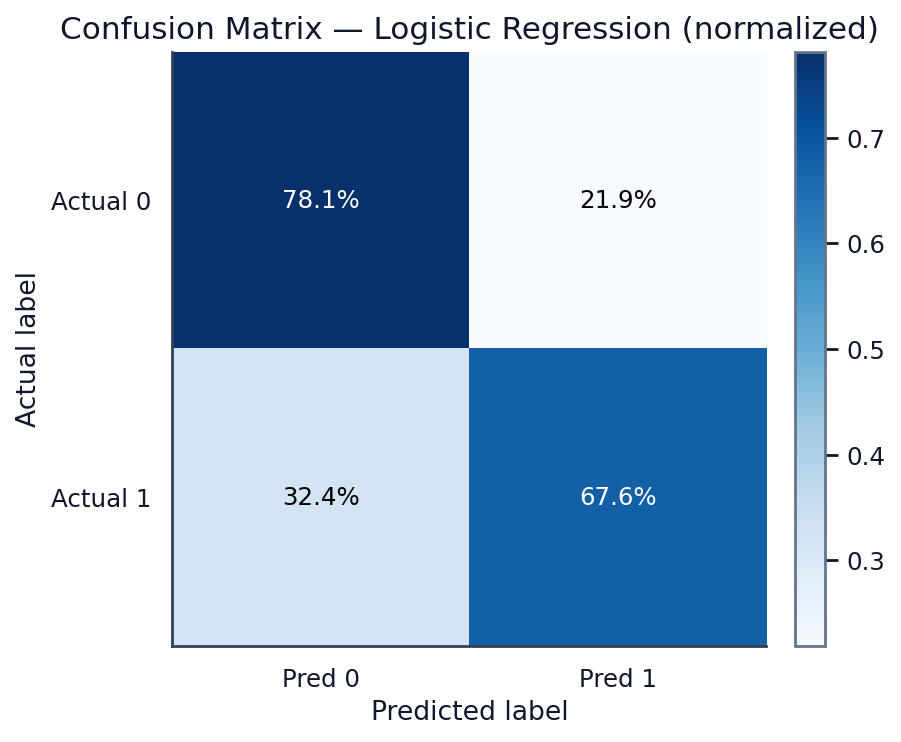

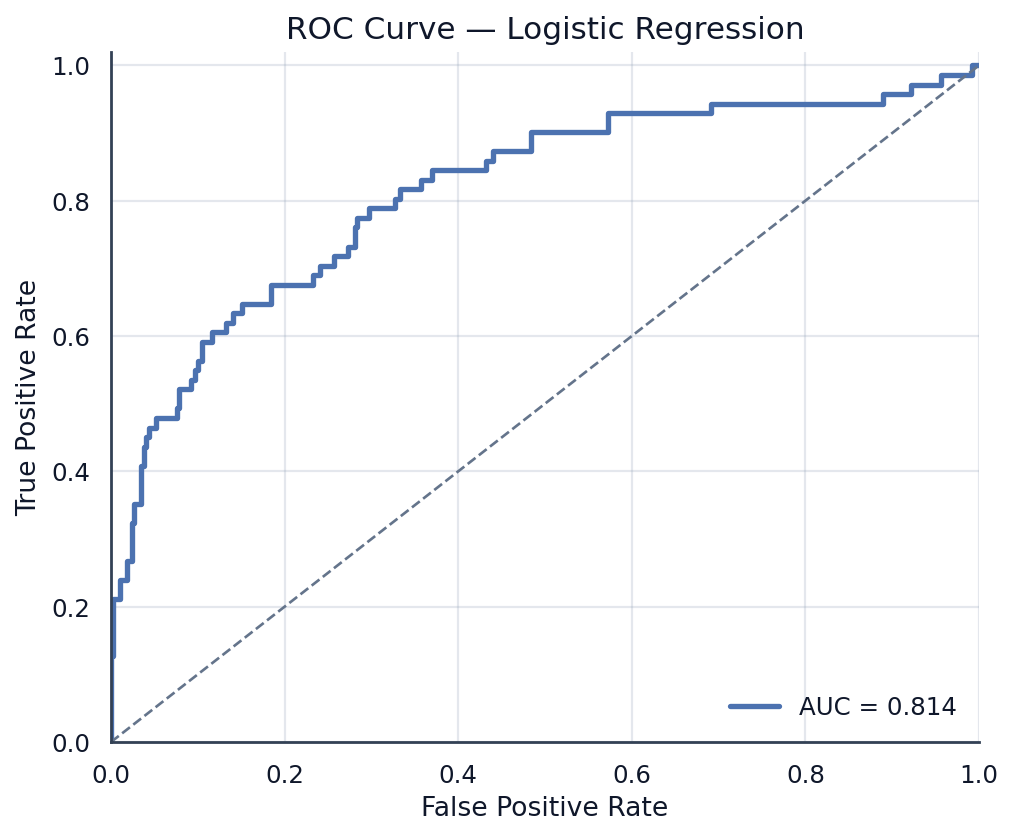

In [78]:
# 6.4 Logistic Regression (Baseline, with class imbalance handling)

log_reg = make_clf(
    LogisticRegression(
        max_iter=1000, class_weight="balanced", solver="liblinear", random_state=42
    )
)

_ = evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression")



Decision Tree Performance
Accuracy : 0.7234
Precision: 0.3139
Recall   : 0.6056
F1-score : 0.4135
ROC-AUC  : 0.6606


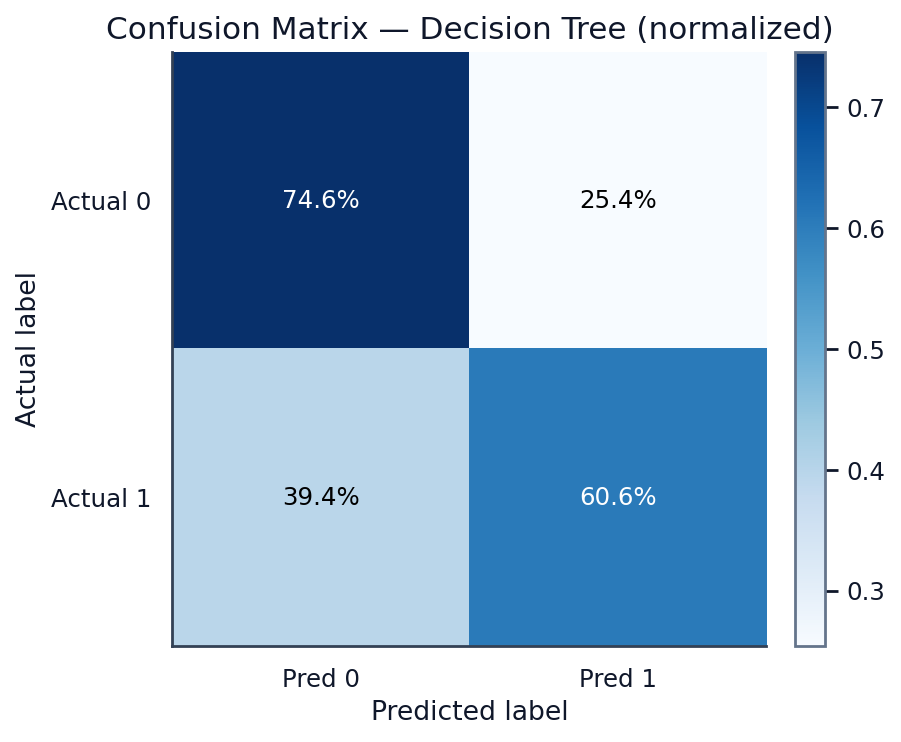

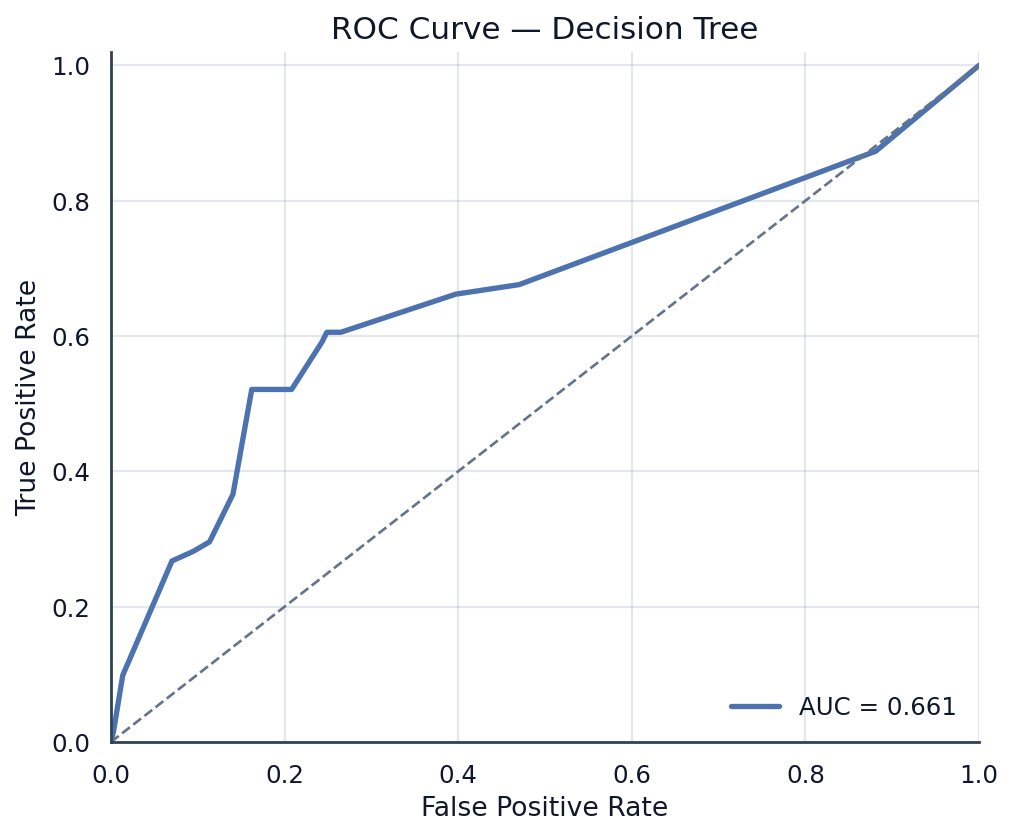

In [79]:
# 6.5 Decision Tree

dt = make_clf(
    DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42)
)

_ = evaluate_model(dt, X_train, y_train, X_test, y_test, "Decision Tree")



Random Forest Performance
Accuracy : 0.8481
Precision: 0.6250
Recall   : 0.1408
F1-score : 0.2299
ROC-AUC  : 0.7738


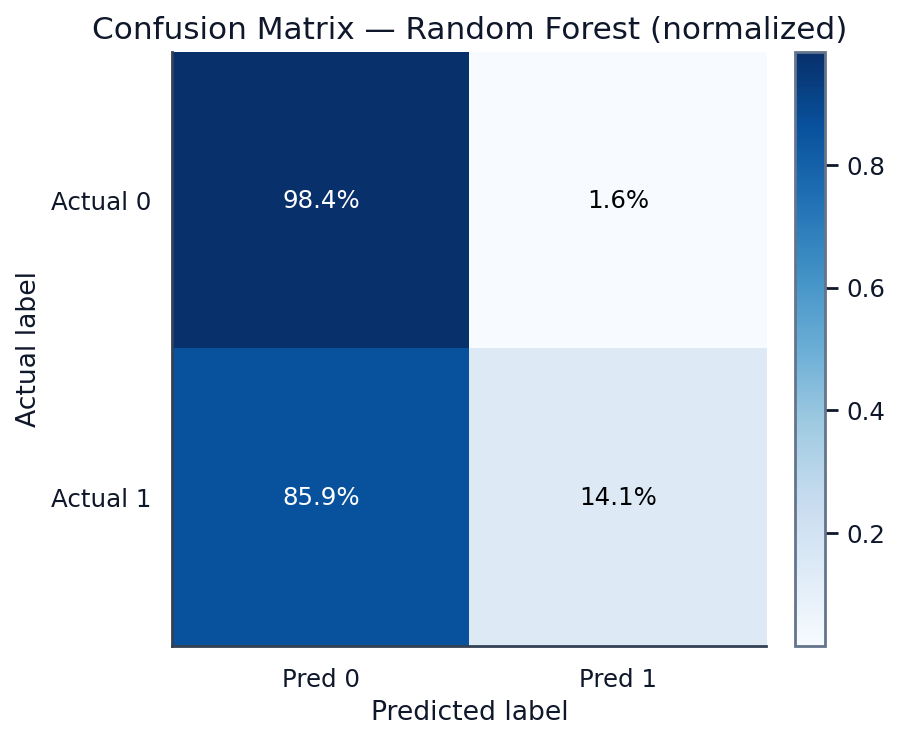

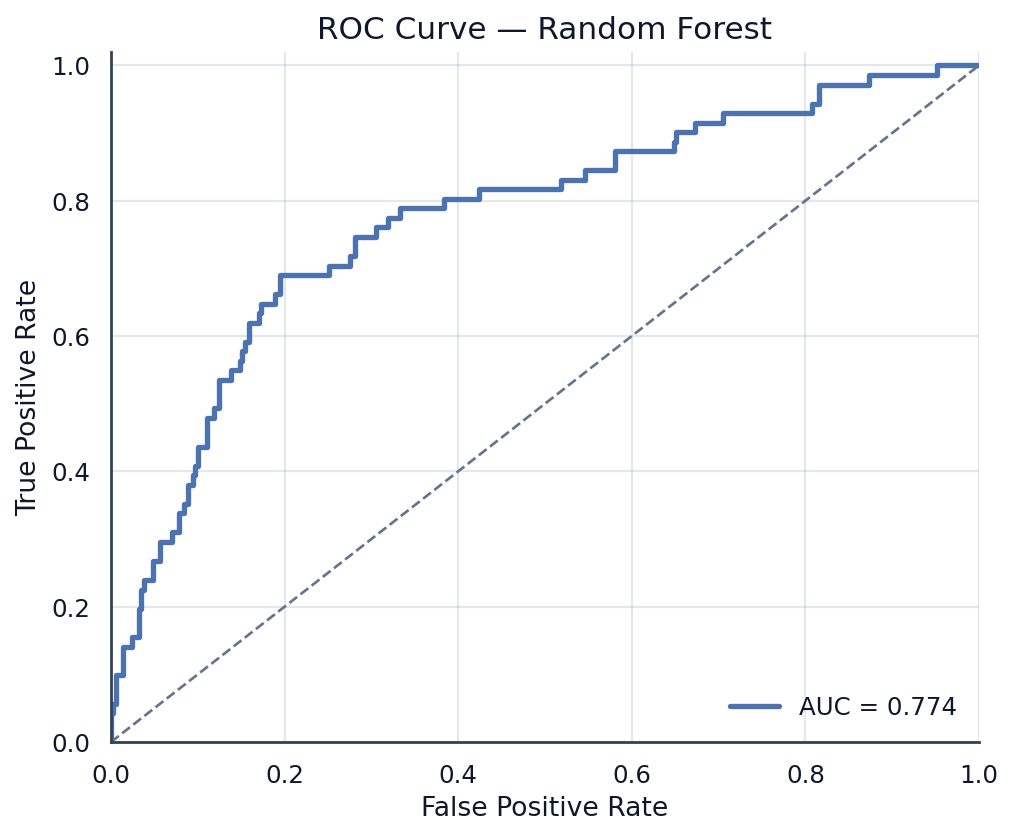

In [80]:
# 6.6 Random Forest

rf = make_clf(
    RandomForestClassifier(
        n_estimators=200, max_depth=10, class_weight="balanced", random_state=42
    )
)

_ = evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest")



SVM Performance
Accuracy : 0.4535
Precision: 0.2069
Recall   : 0.8451
F1-score : 0.3324
ROC-AUC  : 0.7324


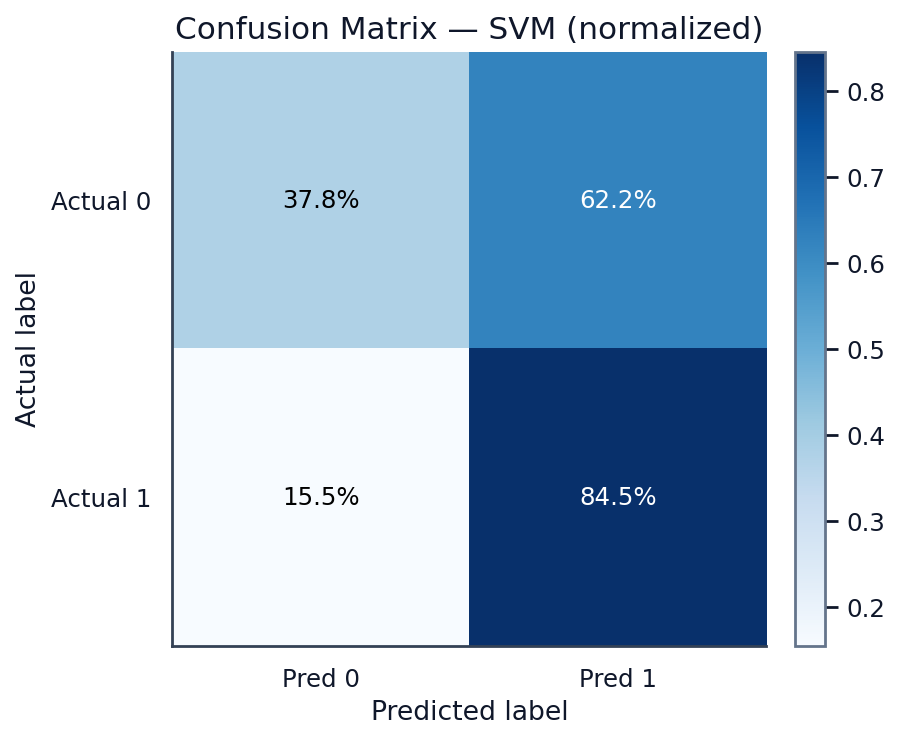

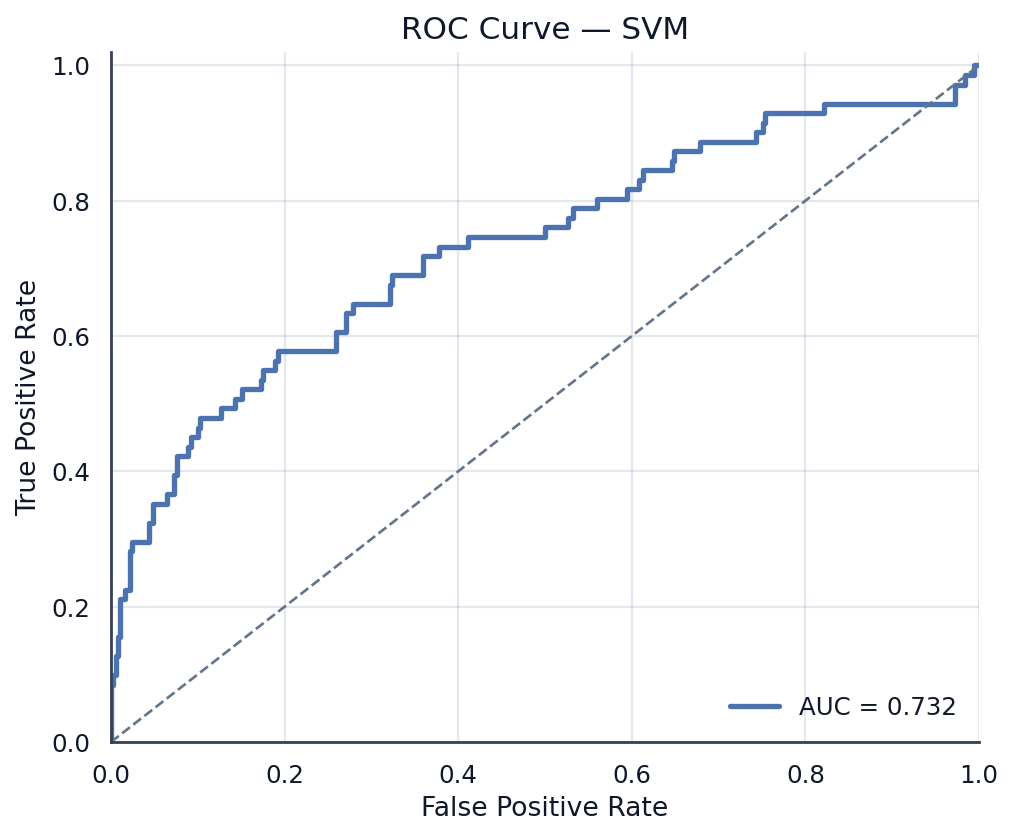

In [81]:
# 6.7 Support Vector Machine (SVM)
# probability=True so we get ROC-AUC; class_weight="balanced" for imbalance

svm = make_clf(
    SVC(probability=True, class_weight="balanced", random_state=42)
)

_ = evaluate_model(svm, X_train, y_train, X_test, y_test, "SVM")



Gradient Boosting Performance
Accuracy : 0.8413
Precision: 0.5172
Recall   : 0.2113
F1-score : 0.3000
ROC-AUC  : 0.7855


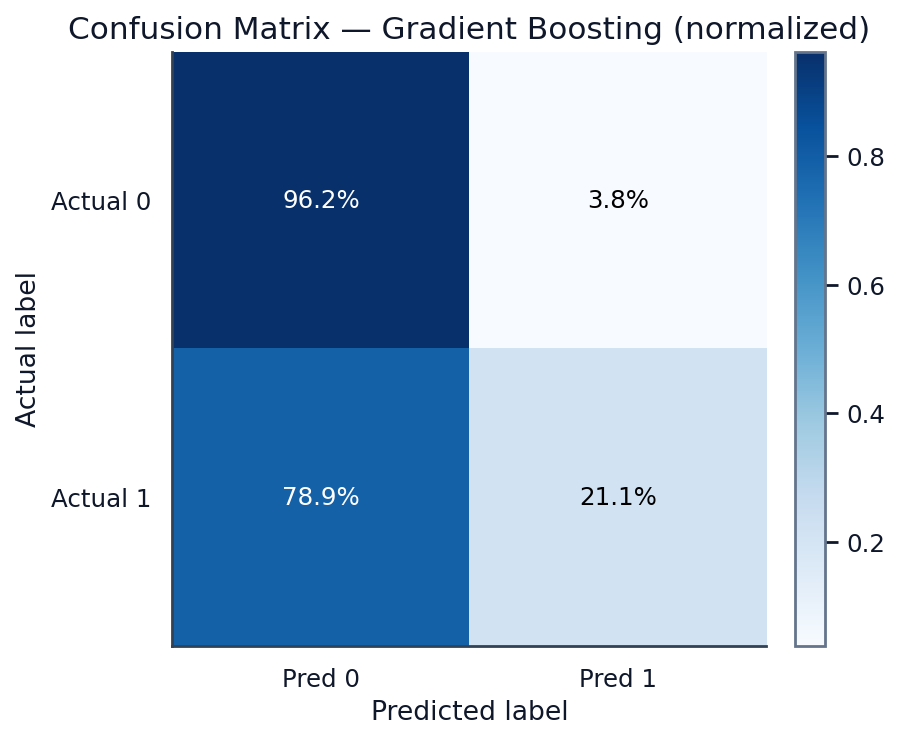

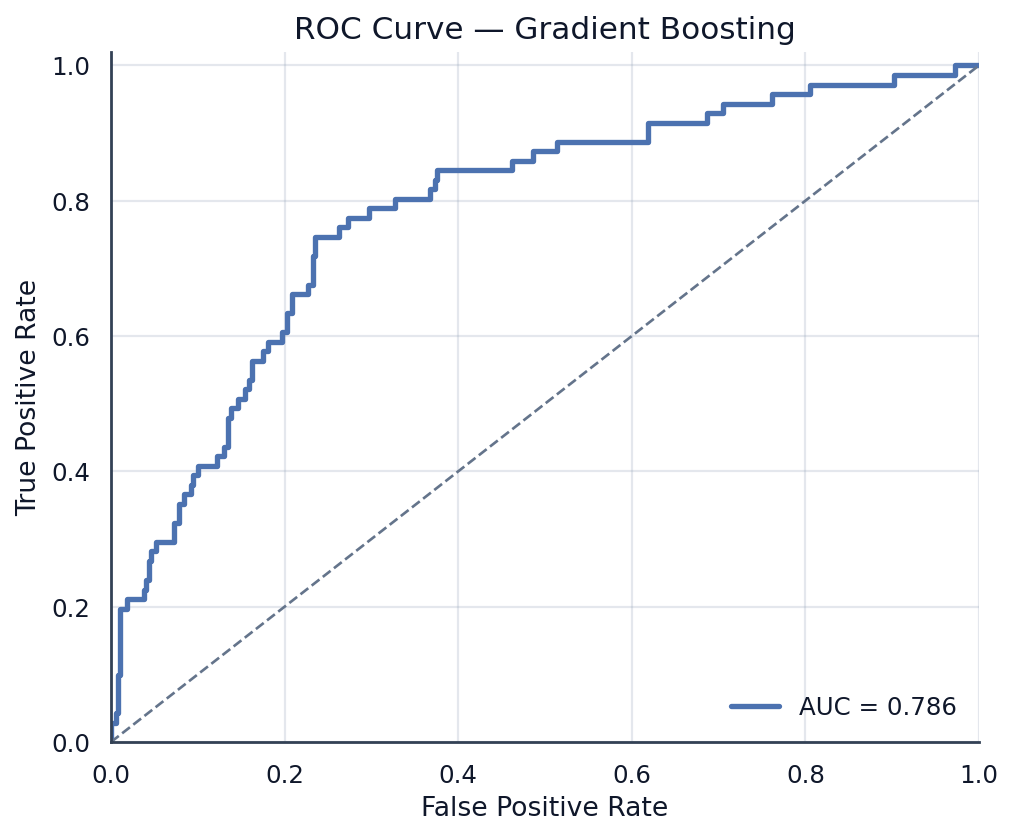

In [82]:
# 6.8 Gradient Boosting (strong baseline boosting model)

gb = make_clf(
    GradientBoostingClassifier(random_state=42)
)

_ = evaluate_model(gb, X_train, y_train, X_test, y_test, "Gradient Boosting")


In [83]:
# 6.9 Compare models (hide index, version-safe)
results_df = pd.DataFrame(results)

try:
    # Newer pandas (>=1.4) supports hide(axis="index")
    display(results_df.style.hide(axis="index"))
except Exception:
    # Fallback if hide(axis="index") not available
    display(results_df)


Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression,0.764000,0.372000,0.676000,0.480000,0.814000
Decision Tree,0.723000,0.314000,0.606000,0.413000,0.661000
Random Forest,0.848000,0.625000,0.141000,0.230000,0.774000
SVM,0.454000,0.207000,0.845000,0.332000,0.732000
Gradient Boosting,0.841000,0.517000,0.211000,0.300000,0.786000


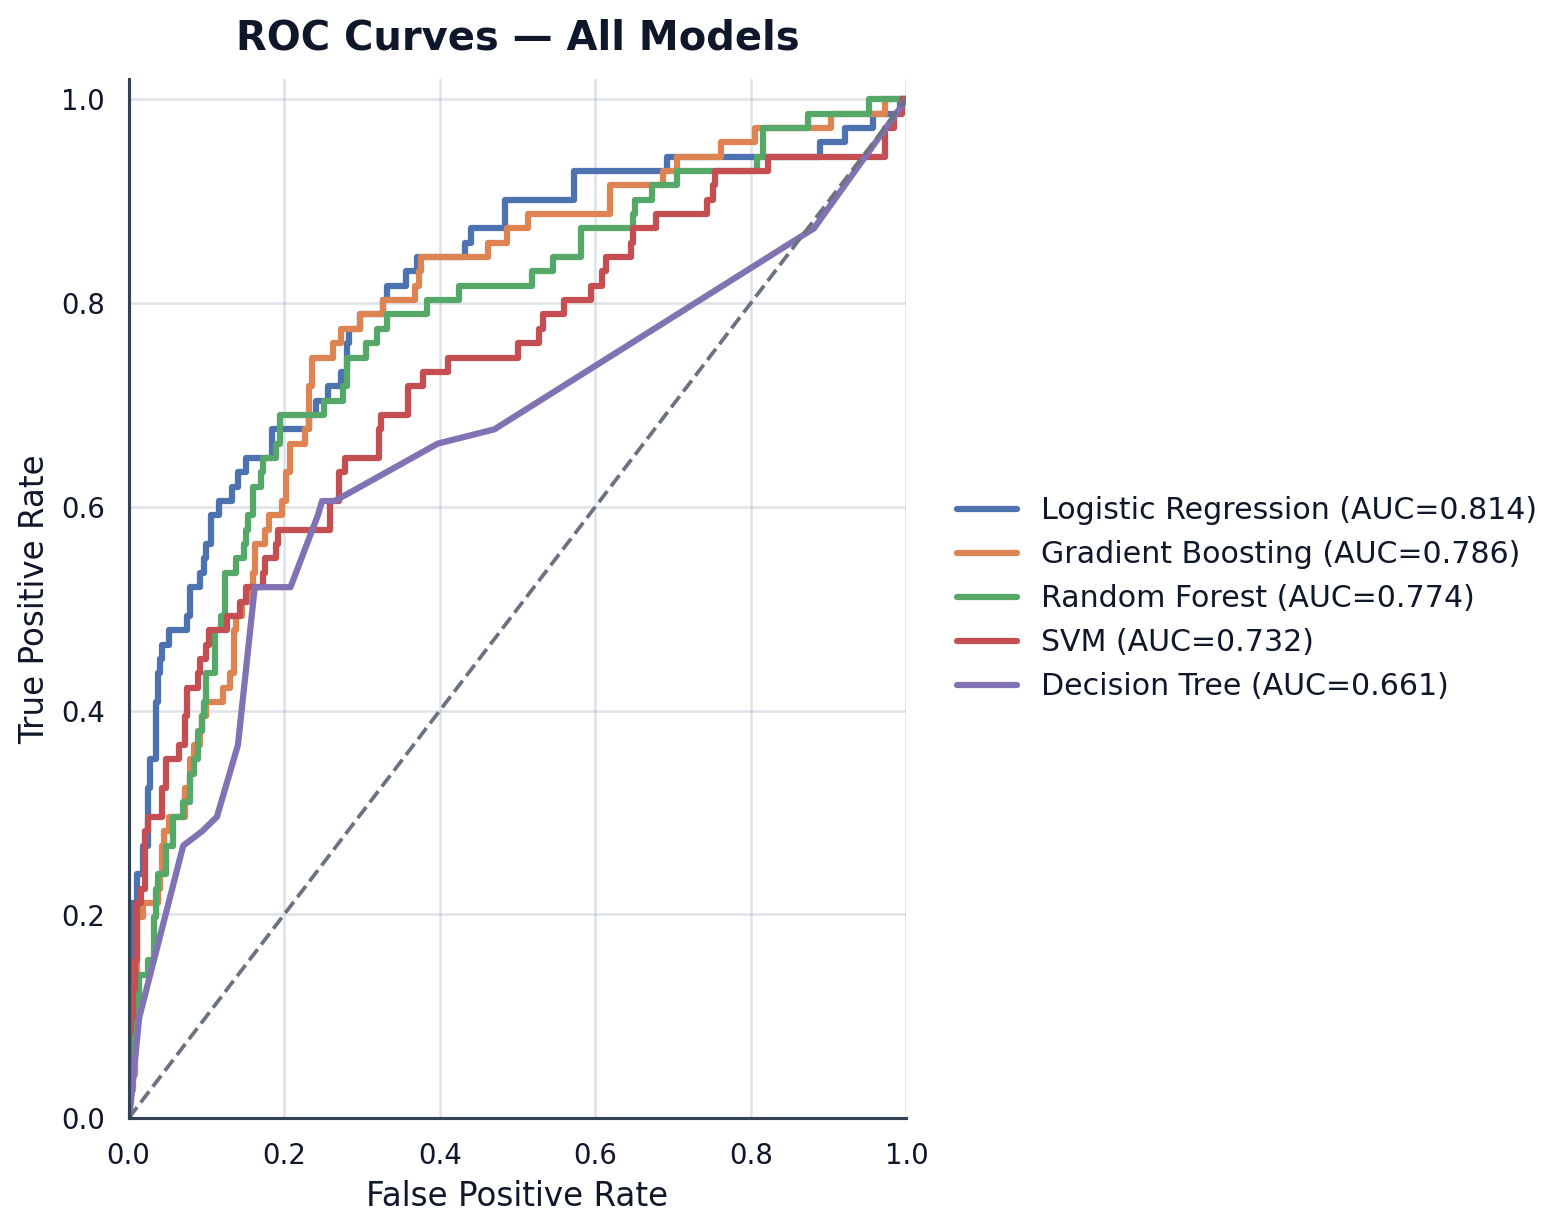

In [84]:
# 6.10 Combined ROC curves — All Models (Bigger & Clearer)

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Collect probabilities
probas = [
    ("Logistic Regression", log_reg.predict_proba(X_test)[:, 1]),
    ("Decision Tree",       dt.predict_proba(X_test)[:, 1]),
    ("Random Forest",       rf.predict_proba(X_test)[:, 1]),
    ("SVM",                 svm.predict_proba(X_test)[:, 1]),
    ("Gradient Boosting",   gb.predict_proba(X_test)[:, 1]),
]

# Build ROC data with AUC
roc_data = []
for name, y_proba in probas:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    roc_data.append((name, fpr, tpr, auc_val))

# Sort by AUC (descending) for neat legend
roc_data.sort(key=lambda x: x[3], reverse=True)

# Bigger, high-DPI figure
plt.figure(figsize=(9, 7), dpi=180)

for name, fpr, tpr, auc_val in roc_data:
    plt.plot(fpr, tpr, linewidth=2.5, label=f"{name} (AUC={auc_val:.3f})")

# Baseline diagonal
plt.plot([0, 1], [0, 1], linestyle="--", color="#6b7280", linewidth=1.5)

# Styling
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("ROC Curves — All Models", fontsize=16, pad=12, weight="bold")
plt.grid(alpha=0.3)

# Legend outside for clarity
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0.,
    frameon=False,
    fontsize=12
)

plt.tight_layout()
plt.show()


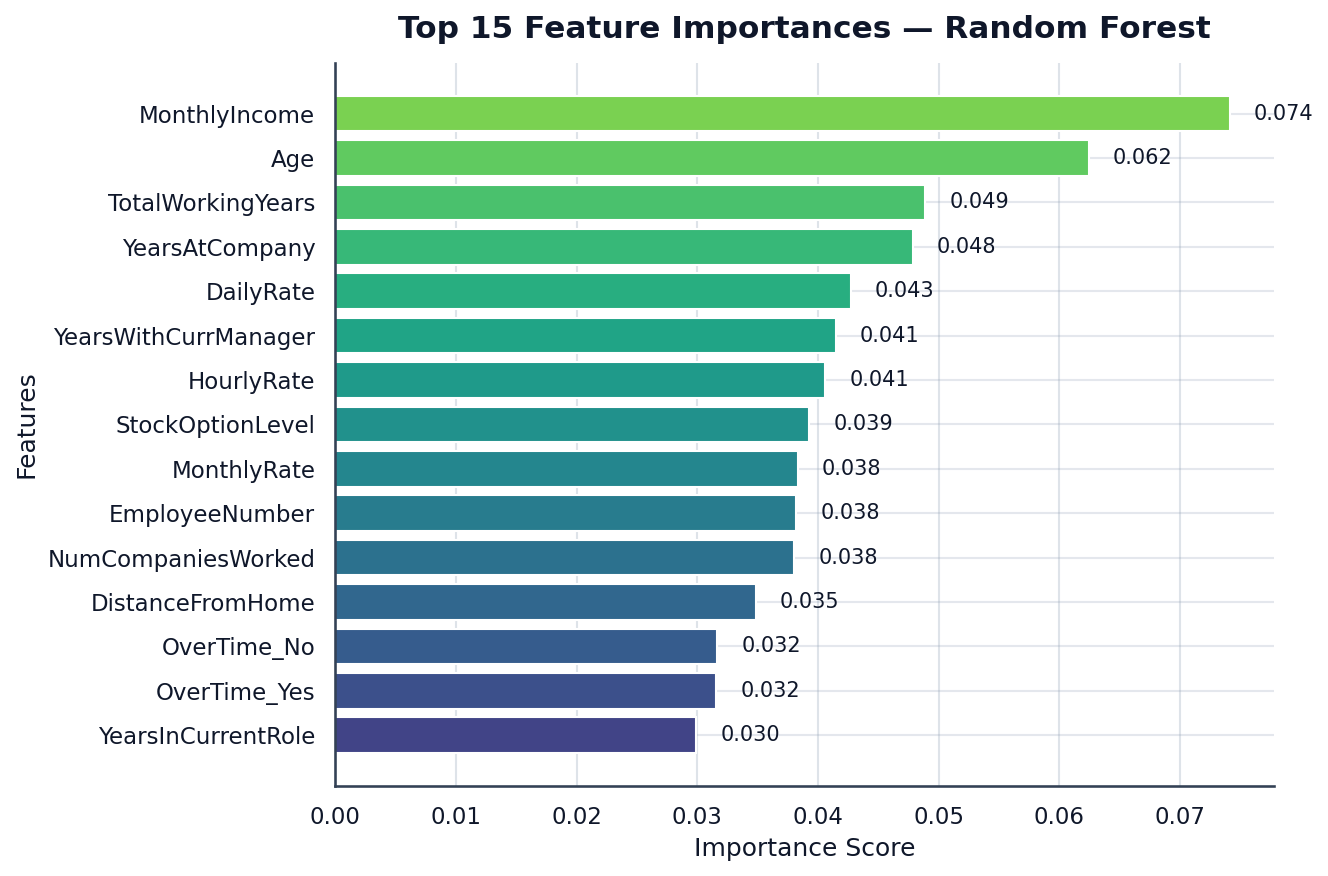

,0
MonthlyIncome,0.074113
Age,0.062425
TotalWorkingYears,0.048908
YearsAtCompany,0.047847
DailyRate,0.042718
YearsWithCurrManager,0.041480
HourlyRate,0.040598
StockOptionLevel,0.039281
MonthlyRate,0.038318
EmployeeNumber,0.038188


In [85]:
# 6.11 Feature Importance — Random Forest (Top 15, Beautiful)

# Extract fitted RF model from pipeline
rf_fitted = rf.named_steps["clf"]

# Feature names (numeric + one-hot categorical)
ohe = rf.named_steps["prep"].named_transformers_["cat"]
num_features = num_cols
cat_features = ohe.get_feature_names_out(cat_cols).tolist()
all_feature_names = num_features + cat_features

# Importance scores
fi = pd.Series(rf_fitted.feature_importances_, index=all_feature_names).sort_values(ascending=False)

# Top 15
top15 = fi.head(15)

# Plot
plt.figure(figsize=(9, 6), dpi=150)
bars = plt.barh(top15.index[::-1], top15.values[::-1], color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top15))))

# Style
plt.title("Top 15 Feature Importances — Random Forest", fontsize=15, pad=12, weight="bold")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis="x", alpha=0.3)

# Annotate values at the end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

top15


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': 8, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
CV best F1 : 0.442485295859156

Random Forest (Tuned) Performance
Accuracy : 0.8413
Precision: 0.5172
Recall   : 0.2113
F1-score : 0.3000
ROC-AUC  : 0.7781


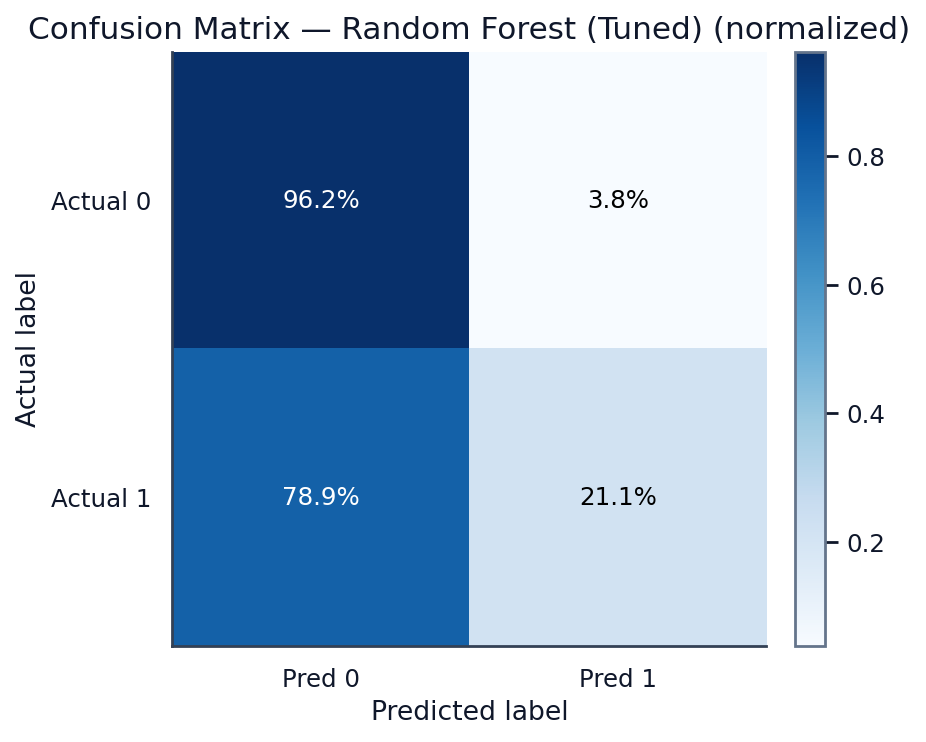

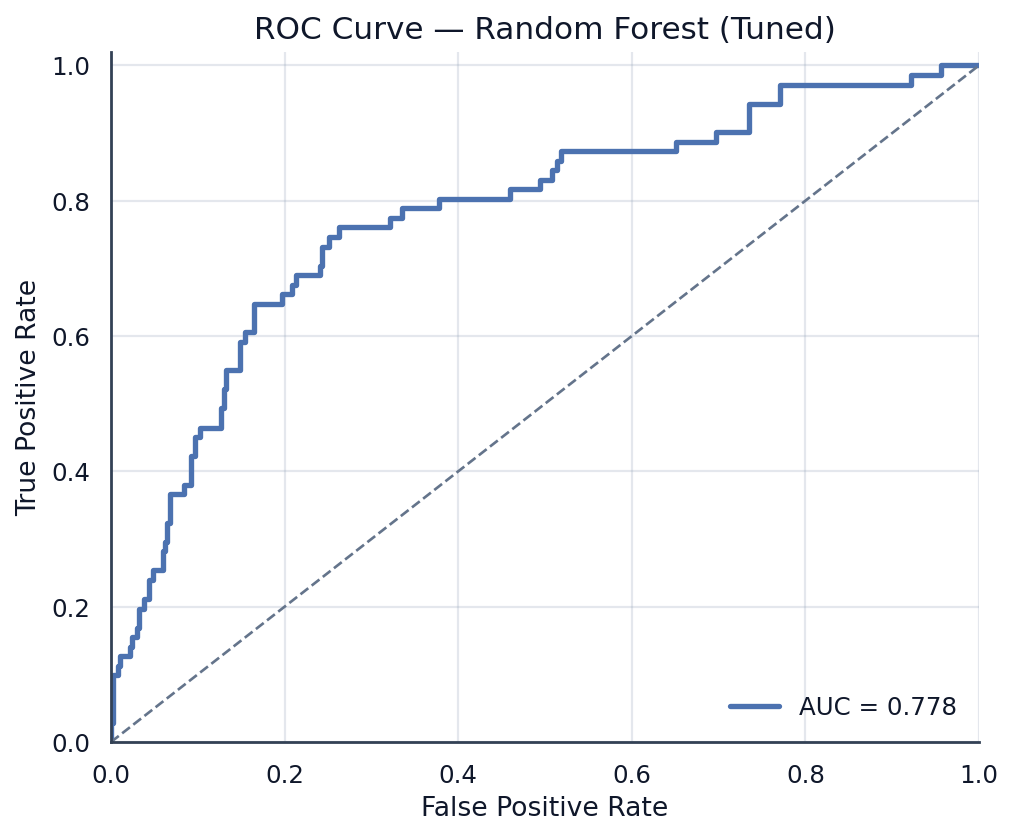

In [86]:
# 6.12 Cross-validated tuning for Random Forest — picks a stronger model

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [8, 12, None],
    "clf__min_samples_split": [2, 5],
}

rf_base = make_clf(RandomForestClassifier(class_weight="balanced", random_state=42))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    rf_base,
    param_grid=param_grid,
    scoring="f1",     # choose "f1" due to class imbalance; you can try "roc_auc" too
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best F1 :", grid.best_score_)

best_rf = grid.best_estimator_
_ = evaluate_model(best_rf, X_train, y_train, X_test, y_test, "Random Forest (Tuned)")


In [87]:
# 6.13 Threshold tuning — improve F1/Recall by moving decision threshold

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Use tuned model if available; else fall back to Logistic Regression pipeline
try:
    mdl = best_rf  # from Cell 13
except NameError:
    mdl = log_reg  # from Cell 5

proba = mdl.predict_proba(X_test)[:, 1]
prec, rec, th = precision_recall_curve(y_test, proba)

# Compute F1 across thresholds
f1s = (2 * prec * rec) / (prec + rec + 1e-9)
best_ix = f1s.argmax()
best_thresh = th[best_ix] if best_ix < len(th) else 0.5

print(f"Best threshold for F1: {best_thresh:.3f} | F1={f1s[best_ix]:.3f} | Precision={prec[best_ix]:.3f} | Recall={rec[best_ix]:.3f}")

# Apply tuned threshold
y_pred_opt = (proba >= best_thresh).astype(int)
print("\nConfusion Matrix @ tuned threshold")
print(confusion_matrix(y_test, y_pred_opt))
print("\nClassification Report @ tuned threshold")
print(classification_report(y_test, y_pred_opt, digits=3))


Best threshold for F1: 0.319 | F1=0.517 | Precision=0.430 | Recall=0.648

Confusion Matrix @ tuned threshold
[[309  61]
 [ 25  46]]

Classification Report @ tuned threshold
              precision    recall  f1-score   support

           0      0.925     0.835     0.878       370
           1      0.430     0.648     0.517        71

    accuracy                          0.805       441
   macro avg      0.678     0.742     0.697       441
weighted avg      0.845     0.805     0.820       441



## Conclusion

Five models were tested to predict attrition. Logistic Regression offered balanced results (Accuracy 76%, Recall 68%, ROC-AUC 0.81) and clear interpretability, making it useful for understanding risk factors. Random Forest initially showed high accuracy (85%) but poor recall; after tuning and adjusting the threshold, it improved to F1 = 0.52 with Recall = 65%, giving a better balance for identifying at-risk employees. Other models (Decision Tree, SVM, Gradient Boosting) performed less consistently. Feature importance revealed that OverTime, MonthlyIncome, and Job Role were the strongest predictors. Business-wise, this indicates that heavy overtime, low salaries, and certain roles (e.g., Sales, Lab Technicians) drive higher attrition, suggesting HR should prioritize workload management, pay reviews, and role-specific retention strategies.


---

